In [ ]:
# First install jax with the correct OS and hardware version
# Follow https://github.com/google/jax?tab=readme-ov-file#installation
# e.g.:
# !pip install -U "jax[cuda12]"

In [ ]:
# package for flows
!pip install flowjax

# my own wrappers for convenience
# you might have to install some other packages because I didn't add install requirements to shallow
!pip install git+https://github.com/mdmould/shallow

In [1]:
import matplotlib.pyplot as plt
from corner import corner
import numpy as np
import jax
import jax.numpy as jnp
from flowjax.distributions import StandardNormal
from flowjax.flows import block_neural_autoregressive_flow
from shallow.jax.flows import bound_from_unbound, trainer

2024-06-10 15:33:33.537452: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# fake data:
n = 10_000

# x dimension is standard normal
x = jax.random.normal(jax.random.PRNGKey(0), (n,))

# y dimension is unit uniform
y = jax.random.uniform(jax.random.PRNGKey(1), (n,))

# stack into single 2D variable
samples = jnp.stack([x, y]).T

In [3]:
samples.shape

(10000, 2)

In [4]:
# this is one specific type of flow as an example
# https://danielward27.github.io/flowjax/api/flows.html#flowjax.flows.block_neural_autoregressive_flow
# just take the default architecture

flow_init = block_neural_autoregressive_flow(
    key = jax.random.PRNGKey(2),
    base_dist = StandardNormal(shape = (2,)), # number of parameter dimensions
)

In [5]:
# physical bounds of the data
bounds = [
    None, # x
    [0, 1], # y
]

# flow lives in Euclidian space, so transform it to physically bounded space
flow_init = bound_from_unbound(flow_init, bounds)

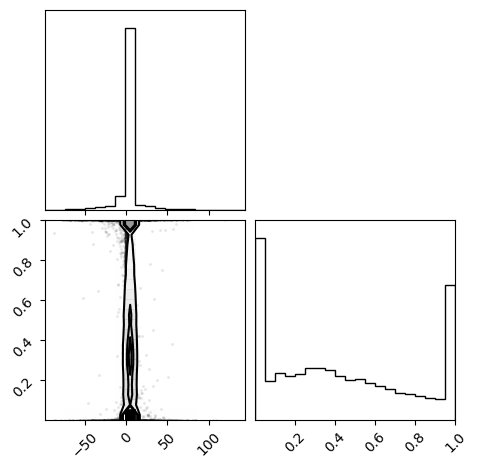

In [6]:
# look at the initial flow
flow_samples = flow_init.sample(jax.random.PRNGKey(3), (10_000,))
corner(np.array(flow_samples));

In [11]:
losses, best_flow, last_flow = trainer(
    key = jax.random.PRNGKey(4),
    flow = flow_init,
    train = samples, # samples used for training
    valid = None, # samples use for validation
    batch_size = None, # size of a minibatch, None means no minibatching
    all_batches = True, # if minibatching, iterate through all minibatches (True) or not (False)
    epochs = 1_000, # number of training steps
    lr = 1e-2, # learning rate
    return_last = True,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
losses.keys()

dict_keys(['train'])

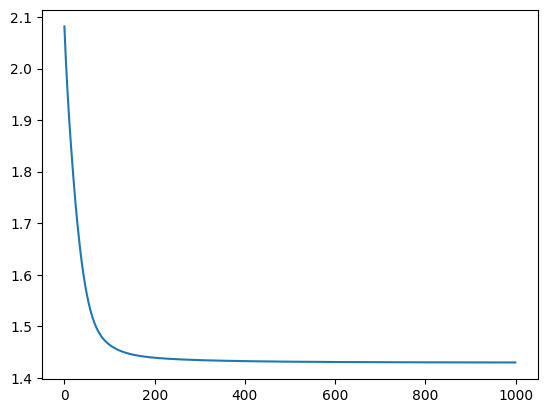

In [12]:
plt.plot(losses['train']);

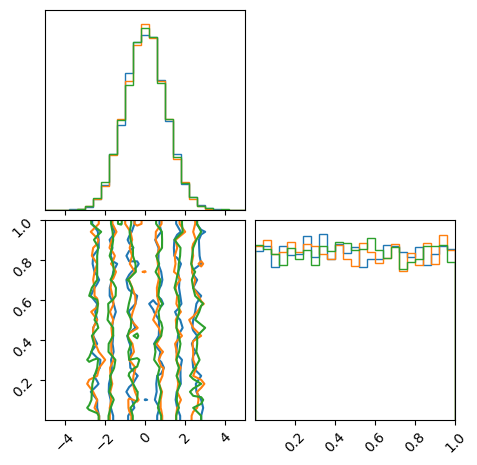

In [13]:
best_samples = best_flow.sample(jax.random.PRNGKey(5), (n,))
last_samples = last_flow.sample(jax.random.PRNGKey(6), (n,))

fig = None
for i, z in enumerate((samples, best_samples, last_samples)):
    c = plt.get_cmap('tab10')(i)
    fig = corner(
        np.array(z),
        fig = fig,
        plot_datapoints = False,
        plot_density = False,
        plot_contours = True,
        fill_contours = False,
        no_fill_contours = True,
        range = [[-5, 5], [0, 1]],
        bins = 25,
        levels = [0.5, 0.9, 0.99],
        hist_kwargs = dict(density = True, color = c),
        contour_kwargs = dict(colors = [c]),
    )